# 1. Import Required Libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model # type: ignore
from tensorflow.keras.layers import LSTM, Dense, Dropout, GRU, SimpleRNN, BatchNormalization # type: ignore
from tensorflow.keras.optimizers import Adam, RMSprop, SGD # type: ignore
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau # type: ignore
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import pickle
import os
from datetime import datetime
import json
from itertools import product
import optuna
import time

warnings.filterwarnings("ignore")

c:\Users\User\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 2. Initialize Global Variables and Helper Functions

In [5]:
SEQUENCE_LENGTH = 12
MODEL_DIR = 'clove_models'

#create model directory if it does not exist
if not os.path.exists(MODEL_DIR):
    os.makedirs(MODEL_DIR)
    print(f"Created model directory: {MODEL_DIR}")

# Initialize preprocessors
scaler_features = StandardScaler()
scaler_target = StandardScaler()
label_encoders = {}

# 3. Data Loading and Preparation Functions

In [6]:
def load_and_prepare_data(data_path):
    """Load and prepare the clove price dataset"""
    # Load data
    print(f"Loading data from {data_path}...")
    df = pd.read_csv(data_path)
    print(f"Initial data shape: {df.shape}")
    print(f"Columns: {df.columns.tolist()}")

    # Convert Month to datetime
    df['Month'] = pd.to_datetime(df['Month'])

    # Handle missing values in Regional_Price
    missing_before = df['Regional_Price'].isna().sum()
    missing_after = df['Regional_Price'].isna().sum()
    print(f"Missing Regional_Price values: {missing_before} -> {missing_after}")

    # Encode categorical variables
    for col in ['Grade', 'Region']:
        if col not in label_encoders: 
            label_encoders[col] = LabelEncoder()
        df[f'{col}_encoded'] = label_encoders[col].fit_transform(df[col])

    # Create additional time-based features
    df['Year'] = df['Month'].dt.year
    df['Month_num'] = df['Month'].dt.month
    df['Quarter'] = df['Month'].dt.quarter

    print("Creating lag and rolling features...")

    # Create lag features for key variables
    df = df.sort_values(['Grade', 'Region', 'Month'])
    lag_columns = ['Regional_Price', 'National_Price', 'Temperature', 'Rainfall', 'Indonesia_Price_in_USD', 'Madagascar_Price_in_USD', 'Tanzania_Price_in_USD', 'Exchange_Rate', 'inflation_Rate']
    for col in lag_columns:
        if col in df.columns:
            for lag in [1, 3, 6, 12]:
                df[f'{col}_lag_{lag}'] = df.groupby(['Grade', 'Region'])[col].shift(lag)

    # Create rolling averages
    rolling_columns = ['Regional_Price', 'National_Price', 'Temperature', 'Rainfall', 'Indonesia_Price_in_USD', 'Madagascar_Price_in_USD', 'Tanzania_Price_in_USD', 'Exchange_Rate', 'inflation_Rate']
    for col in rolling_columns:
        if col in df.columns:
            for window in [3, 6, 12]:
                df[f'{col}_rolling_{window}'] = df.groupby(['Grade', 'Region'])[col].transform(
                    lambda x: x.rolling(window).mean()
                )

    print(f"Final data shape after feature engineering: {df.shape}")
    print(f"Unique grades: {df['Grade'].unique()}")
    print(f"Unique regions: {df['Region'].unique()}")

    return df

# 4. Load Data

In [7]:
DATA_PATH = 'C:/VERGER/Spice_Price_Prediction/Clove/Datasets/Clove_Dataset.csv'
df = load_and_prepare_data(DATA_PATH)
print("\nData loaded successfully!")
print(f"Shape: {df.shape}")
print("\nFirst few rows:")
df.head()

Loading data from C:/VERGER/Spice_Price_Prediction/Clove/Datasets/Clove_Dataset.csv...
Initial data shape: (1470, 17)
Columns: ['Month', 'Grade', 'Region', 'Regional_Price', 'National_Price', 'Seasonal_Impact', 'Indonesia_Price_in_USD', 'Madagascar_Price_in_USD', 'Tanzania_Price_in_USD', 'Local_Production_Volume', 'Local_Export_Volume', 'Global_Production_Volume', 'Temperature', 'Rainfall', 'Exchange_Rate', 'Inflation_Rate', 'Fuel_Price']
Missing Regional_Price values: 0 -> 0
Creating lag and rolling features...
Final data shape after feature engineering: (1470, 78)
Unique grades: ['Clove' 'Stem']
Unique regions: ['Badulla' 'Colombo' 'Galle' 'Gampaha' 'Hambantota' 'Kalutara' 'Kandy'
 'Kegalle' 'Kurunegala' 'Matale' 'Matara' 'Monaragala' 'Nuwaraeliya'
 'Ratnapura']

Data loaded successfully!
Shape: (1470, 78)

First few rows:


,Month,Grade,Region,Regional_Price,National_Price,Seasonal_Impact,Indonesia_Price_in_USD,Madagascar_Price_in_USD,Tanzania_Price_in_USD,Local_Production_Volume,...,Indonesia_Price_in_USD_rolling_12,Madagascar_Price_in_USD_rolling_3,Madagascar_Price_in_USD_rolling_6,Madagascar_Price_in_USD_rolling_12,Tanzania_Price_in_USD_rolling_3,Tanzania_Price_in_USD_rolling_6,Tanzania_Price_in_USD_rolling_12,Exchange_Rate_rolling_3,Exchange_Rate_rolling_6,Exchange_Rate_rolling_12
5,2020-01-01,Clove,Badulla,858.0,942.22,1,3.90,4.50,4.90,2013.2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
26,2020-02-01,Clove,Badulla,907.0,946.73,1,3.85,4.45,4.85,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
47,2020-03-01,Clove,Badulla,881.0,898.65,0,3.80,4.40,4.80,0.0,...,NaN,4.450000,NaN,NaN,4.850000,NaN,NaN,182.674367,NaN,NaN
68,2020-04-01,Clove,Badulla,818.5,829.24,0,3.70,4.30,4.75,0.0,...,NaN,4.383333,NaN,NaN,4.800000,NaN,NaN,186.568300,NaN,NaN
89,2020-05-01,Clove,Badulla,846.5,843.36,0,3.65,4.25,4.75,0.0,...,NaN,4.316667,NaN,NaN,4.766667,NaN,NaN,188.669033,NaN,NaN


# 5. Price Distribution by Grade

<Figure size 1400x800 with 0 Axes>

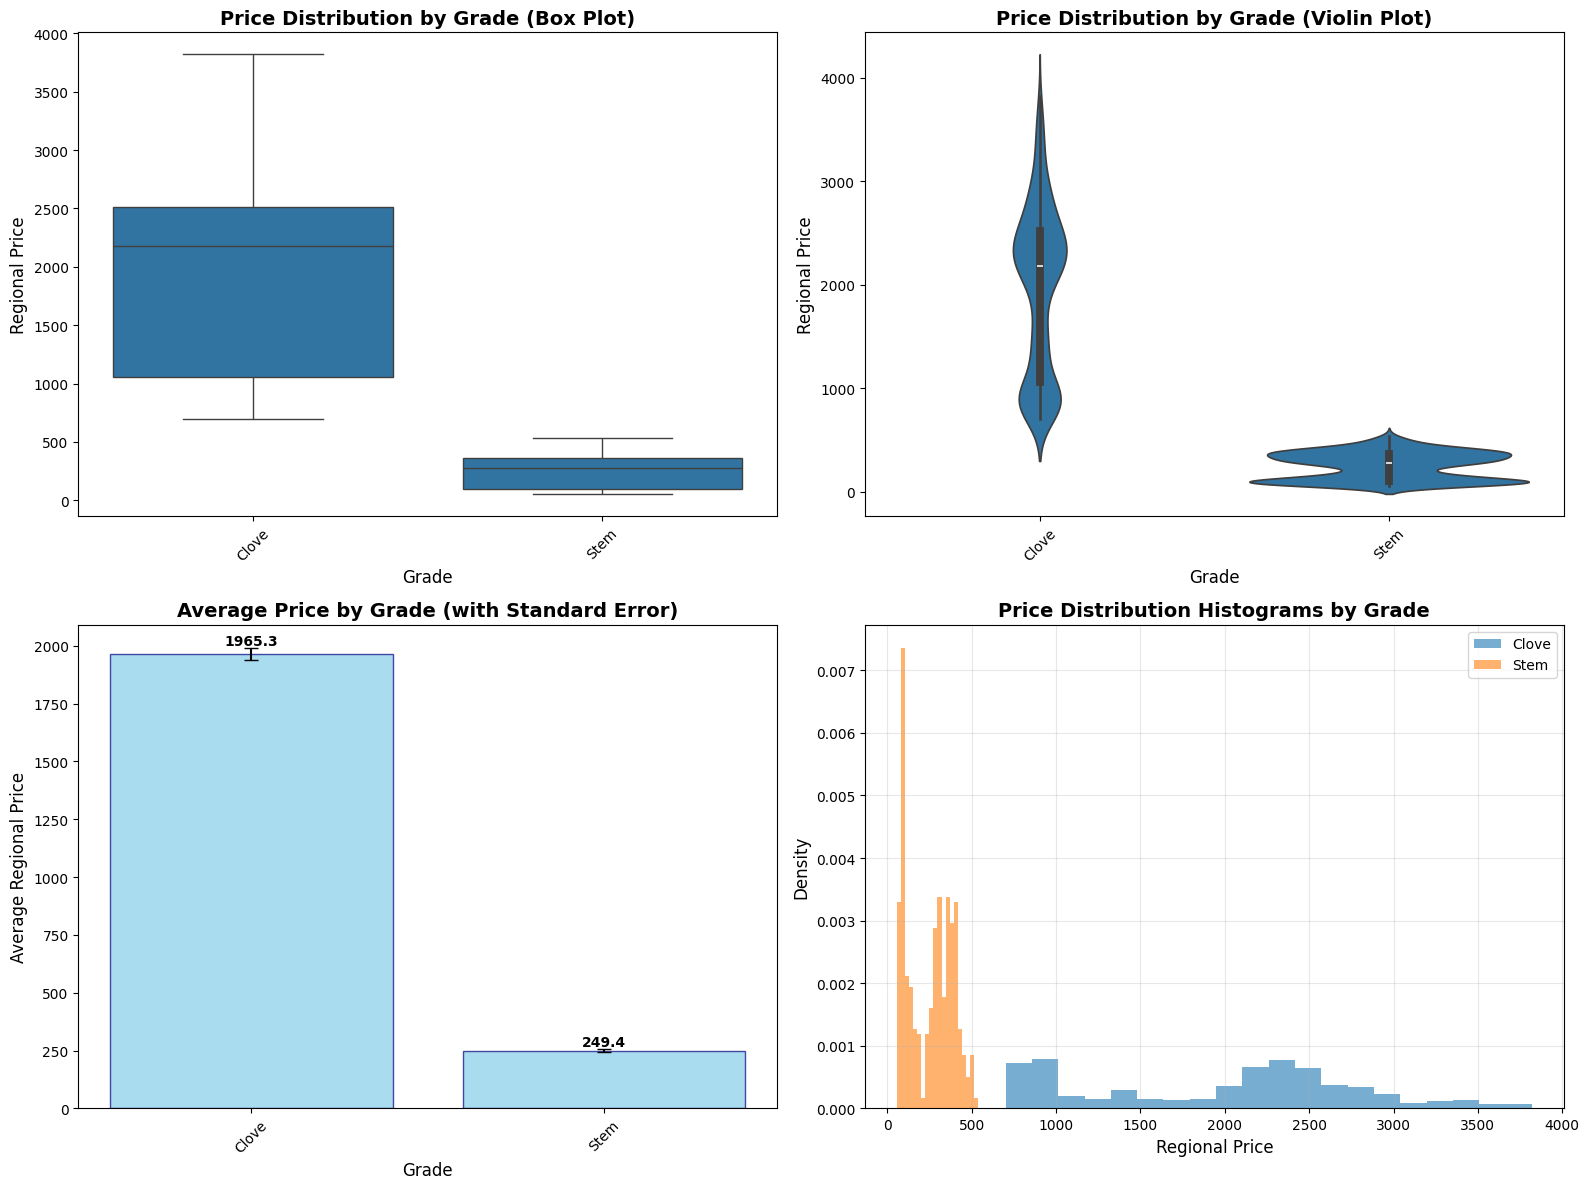


Price Distribution Summary by Grade:
       count     mean     std    min      25%      50%      75%     max
Grade                                                                  
Clove  980.0  1965.32  801.88  700.0  1058.83  2181.62  2514.50  3821.0
Stem   490.0   249.43  133.09   55.0   100.81   279.00   365.75   537.5


In [8]:
def plot_price_distribution_by_grade(df):
    """Plot price distribution by grade"""
    plt.figure(figsize=(14, 8))
    
    # Remove rows with missing Regional_Price
    df_clean = df.dropna(subset=['Regional_Price'])
    
    # Create subplots for different visualizations
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
    
    # 1. Box plot of prices by grade
    sns.boxplot(data=df_clean, x='Grade', y='Regional_Price', ax=ax1)
    ax1.set_title('Price Distribution by Grade (Box Plot)', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Grade', fontsize=12)
    ax1.set_ylabel('Regional Price', fontsize=12)
    ax1.tick_params(axis='x', rotation=45)
    
    # 2. Violin plot for detailed distribution
    sns.violinplot(data=df_clean, x='Grade', y='Regional_Price', ax=ax2)
    ax2.set_title('Price Distribution by Grade (Violin Plot)', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Grade', fontsize=12)
    ax2.set_ylabel('Regional Price', fontsize=12)
    ax2.tick_params(axis='x', rotation=45)
    
    # 3. Mean prices by grade with error bars
    grade_stats = df_clean.groupby('Grade')['Regional_Price'].agg(['mean', 'std', 'count']).reset_index()
    grade_stats['se'] = grade_stats['std'] / np.sqrt(grade_stats['count'])
    
    ax3.bar(grade_stats['Grade'], grade_stats['mean'], 
            yerr=grade_stats['se'], capsize=5, alpha=0.7, color='skyblue', edgecolor='navy')
    ax3.set_title('Average Price by Grade (with Standard Error)', fontsize=14, fontweight='bold')
    ax3.set_xlabel('Grade', fontsize=12)
    ax3.set_ylabel('Average Regional Price', fontsize=12)
    ax3.tick_params(axis='x', rotation=45)
    
    # Add value labels on bars
    for i, (grade, mean_price) in enumerate(zip(grade_stats['Grade'], grade_stats['mean'])):
        ax3.text(i, mean_price + grade_stats['se'].iloc[i], f'{mean_price:.1f}', 
                ha='center', va='bottom', fontweight='bold')
    
    # 4. Histogram of all prices colored by grade
    for grade in df_clean['Grade'].unique():
        grade_data = df_clean[df_clean['Grade'] == grade]['Regional_Price']
        ax4.hist(grade_data, alpha=0.6, label=grade, bins=20, density=True)
    
    ax4.set_title('Price Distribution Histograms by Grade', fontsize=14, fontweight='bold')
    ax4.set_xlabel('Regional Price', fontsize=12)
    ax4.set_ylabel('Density', fontsize=12)
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print("\nPrice Distribution Summary by Grade:")
    print("=" * 50)
    summary_stats = df_clean.groupby('Grade')['Regional_Price'].describe()
    print(summary_stats.round(2))

plot_price_distribution_by_grade(df)